# Simple math evaluation dataset benchmark  

Here is the question: how many times can we add 1 and get the correct answer from an LLM ?  

1+1 = 2  

But does 1+1+1+1+1+1+1+1+1+1 = 10 ?  

In this notebook, we will try different methods to force the LLM to answer in a format that we can safely evaluate.  

We will test:  
- unconstrained output on only 2 tokens  
- ouput enforcer on a regex to get 1 to 3 digits  
- output enforcer on a regex to get a single letter from ABCD  
- read logit probas on the last token to evaluate ABCD tokens  
- enable long form answers (64 tokens-long allowed) and perform RAG to find the closest choice answer

We will create two datasets:  
- dataset of "1+1+...+1" sums and their associated correct sum.  
- MMLU style multiple choice dataset creation to need a letter instead of a number to answer a question  

## install libs

In [1]:
%%capture
!pip install transformers datasets
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes
!pip install -U sentence-transformers
!pip install faiss-cpu
!pip install lm-format-enforcer

## Create dataset  

We will create a simple "+1" sum with results ranging from 2 to 100.  
We skip the first line that is 1 = 1 as we are only interested in sums (so we start at 1+1 = 2).  
Therefore, the complete dataset will have 99 rows.  

In [2]:
import pandas as pd

addition_list = []
ones_list = []
for i in range(100):
  ones_list.append('1')
  addition_list.append({
      'sum' : '+'.join(ones_list),
      'result' : str(i+1)
      })

additions_df = pd.DataFrame(addition_list)

# we remove the first line that doesn't contain a sum (single one)
additions_df = additions_df[additions_df['result'] != '1']

additions_df.head()

,sum,result
1,1+1,2
2,1+1+1,3
3,1+1+1+1,4
4,1+1+1+1+1,5
5,1+1+1+1+1+1,6


In [3]:
from datasets import Dataset

addition_dataset = Dataset.from_pandas(additions_df)
addition_dataset

# we will use this later, apply for now

Dataset({
    features: ['sum', 'result', '__index_level_0__'],
    num_rows: 99
})

## load model

In [4]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)
model.generation_config.pad_token_id = tokenizer.pad_token_id

# set up temperature
model.generation_config.temperature = 0.001

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: NVIDIA GeForce RTX 3090. Max memory: 23.999 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2. CUDA = 8.6. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## define open ended inference function  

We let the LLM answer with 2 tokens of its choosing.  
We then assert whether the answer is correct or not.  

In [5]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

FastLanguageModel.for_inference(model) # Enable native 2x faster inference

def get_answer_to_question(question):

  prompt = alpaca_prompt.format(
          "Compute the result of this sum.", # instruction
          question, # input
          "", # output - leave this blank for generation!
      )

  inputs = tokenizer([prompt], return_tensors = "pt").to("cuda")

  outputs = model.generate(**inputs, max_new_tokens = 2, use_cache = True)
  return (tokenizer.batch_decode(outputs, skip_special_tokens=True)[0][len(prompt):].strip())

response = get_answer_to_question('1+1')
print(response)

2


## apply open ended inference to complete dataset

In [6]:
from tqdm.auto import tqdm

tqdm.pandas()

additions_df['inferred_answer'] = additions_df.progress_apply(lambda row: get_answer_to_question(row['sum']), axis=1)
additions_df.head()

  0%|          | 0/99 [00:00<?, ?it/s]

,sum,result,inferred_answer
1,1+1,2,2
2,1+1+1,3,3
3,1+1+1+1,4,4
4,1+1+1+1+1,5,5
5,1+1+1+1+1+1,6,6


In [7]:
# add a feature to indicate if the answer is correct
additions_df['is_correct'] = additions_df['result'] == additions_df['inferred_answer']
additions_df.head()

,sum,result,inferred_answer,is_correct
1,1+1,2,2,True
2,1+1+1,3,3,True
3,1+1+1+1,4,4,True
4,1+1+1+1+1,5,5,True
5,1+1+1+1+1+1,6,6,True


### Ratio of correct / incorrect (accuracy)  

We show how many correct and incorrect answers are found in a bar plot.  
Then display the accuracy percentage.  

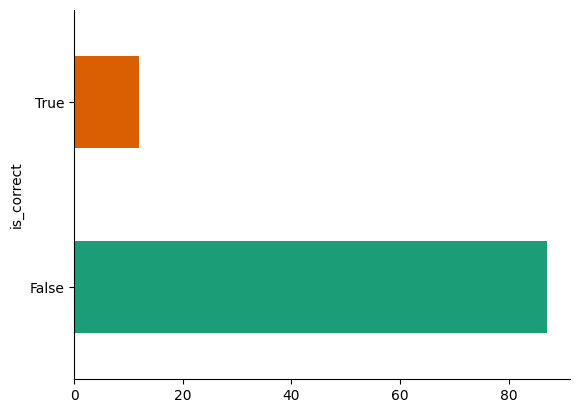

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
additions_df.groupby('is_correct').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:
print(f"Average accuracy : {additions_df.is_correct.mean()*100:.02f}%")

Average accuracy : 12.12%


### Where are the correct answers?

/tmp/ipykernel_43/4247823890.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


Text(0.5, 0, 'Sum')

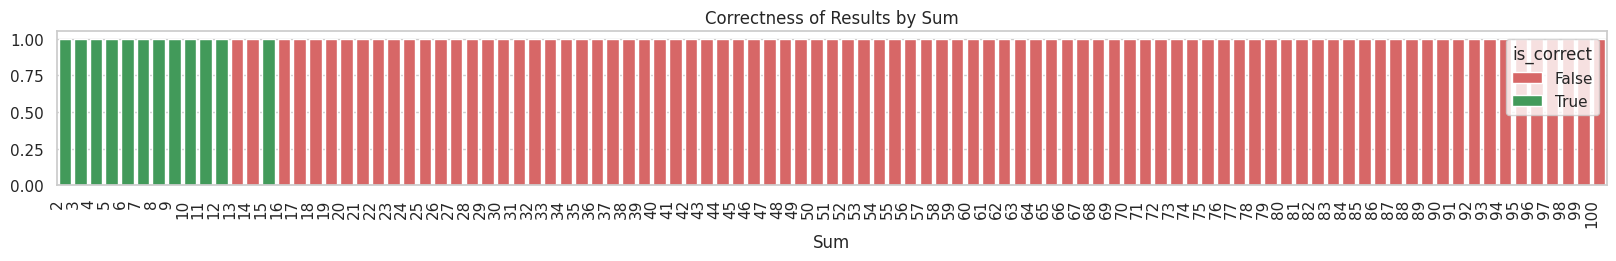

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Order the results
results = additions_df['result'].astype(int).unique()
results.sort()

# set the high and width
plt.figure(figsize=(20, 2))

# Create the barplot
g = sns.barplot(x="result", y=[1]*len(additions_df), data=additions_df, order=results, hue="is_correct", palette=["#EA5455", "#34A853"])

# pivot label
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")

# Add title and labels
plt.title("Correctness of Results by Sum")
plt.xlabel("Sum")


### Limits to the pure open ended method  

We observe many answers that are not numbers.  
A "true" open ended would require many more tokens availiable for the LLM to have a chance to give a long answer. In the current open ended method, we only give 2 tokens. Thus some answers are truncated sentences instead of the direct expected sentence.  
It is hard to evaluate an LLM when the answer is a long form text.  

We are expecting a number, and the answer could contain it.  
However, by parsing the answer for said number, we could incorrectly assert a correct answer from a partial extraction (eg. "The answer is 1000" => string contains "100" so the answer is correct).  

There are many ways to approach this issue:  
- parsing (NER extraction to find numbers, REGEX)  
- RAG to match answers close to the expected  
- creating a multiple choice question with 4 options referenced by a letter  
- using an output enforcer system

We choose the two last options:  

* output enforcer: this will guide the LLM to use only tokens that are numbers and still allow some freedom to answer truthfully in the limited tokens we allow.  

* Multiple choice: this is similar to other benchmarks, like MMLU. We will measure the token probas for letters ABCD in the output.  

As giving more tokens makes the benchmark slower, we have to rely on single token evaluation.  


/tmp/ipykernel_43/2706793522.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


Text(0.5, 0, 'Sum')

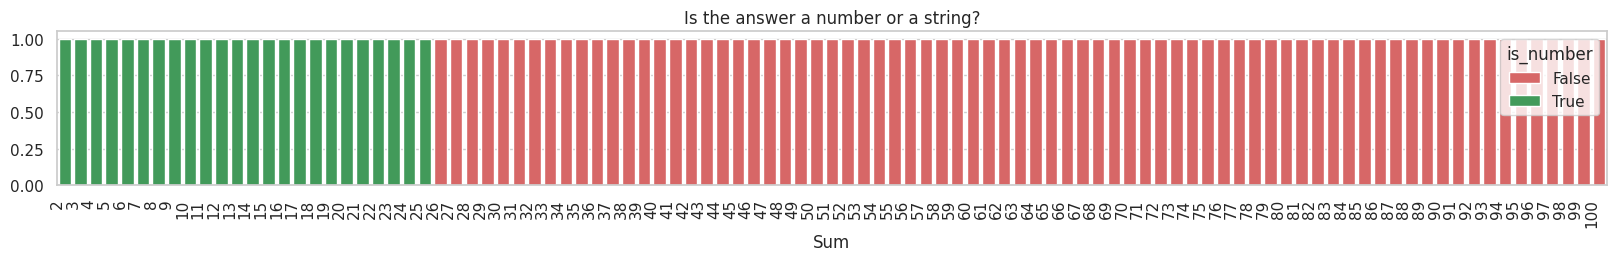

In [11]:
# Function to check if the value is an integer
def check_type(value):
    try:
        int(value)
        return True
    except ValueError:
        return False

# Apply the function to create a new column
additions_df['is_number'] = additions_df['inferred_answer'].apply(check_type)


# Order the results
results = additions_df['result'].astype(int).unique()
results.sort()

# set the high and width
plt.figure(figsize=(20, 2))

# Create the barplot
g = sns.barplot(x="result", y=[1]*len(additions_df), data=additions_df, order=results, hue="is_number", palette=["#EA5455", "#34A853"])

# pivot label
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")

# Add title and labels
plt.title("Is the answer a number or a string?")
plt.xlabel("Sum")

## Open ended inference - with output enforcer  

We use lib `lm-format-enforcer`:  
https://github.com/noamgat/lm-format-enforcer/tree/main  

We will use this enforcer to select tokens that are allowed by a regex.  
In this particular case, we want numbers from 2 to 100, so 0-9 range digits with a cardinality 1-3.  



### setup expected regex and define inference function  

We retrieve most of the inference function from the previous step.  

We first define a tokenzier_data and a parser, then passe them to the `generate_enforced()` function in place of the old `generate()`

In [12]:
from typing import Tuple, Optional, Union, List
import pandas as pd
from lmformatenforcer import JsonSchemaParser, CharacterLevelParser, RegexParser, StringParser
from lmformatenforcer.integrations.transformers import generate_enforced, build_token_enforcer_tokenizer_data

tokenizer_data = build_token_enforcer_tokenizer_data(tokenizer)

# regex for a number between 1 and 3 digits
required_regex = r"\d{1,3}"
parser = RegexParser(required_regex)

In [13]:
def get_enforced_answer_to_question(question: str) -> str:

  prompt = alpaca_prompt.format(
          "Compute the result of this sum.", # instruction
          question, # input
          "", # output - leave this blank for generation!
      )

  inputs = tokenizer([prompt], return_tensors = "pt").to("cuda")

  # outputs = model.generate(**inputs, max_new_tokens = 2, use_cache = True)
  outputs = generate_enforced(model, tokenizer_data, parser, **inputs)
  return (tokenizer.batch_decode(outputs, skip_special_tokens=True)[0][len(prompt):].strip())

In [14]:
question = '100+100'
get_enforced_answer_to_question(question)

'200'

### perform enforced inference on complete dataset

In [15]:
# copy the dataset
additions_df_enforced = additions_df.copy(deep=True)

additions_df_enforced['inferred_answer'] = additions_df_enforced.progress_apply(lambda row: get_enforced_answer_to_question(row['sum']), axis=1)
additions_df_enforced.head()

  0%|          | 0/99 [00:00<?, ?it/s]

,sum,result,inferred_answer,is_correct,is_number
1,1+1,2,2,True,True
2,1+1+1,3,3,True,True
3,1+1+1+1,4,4,True,True
4,1+1+1+1+1,5,5,True,True
5,1+1+1+1+1+1,6,6,True,True


In [16]:
# add is_correct feature
additions_df_enforced['is_correct'] = additions_df_enforced['result'] == additions_df_enforced['inferred_answer']
additions_df_enforced.head()

,sum,result,inferred_answer,is_correct,is_number
1,1+1,2,2,True,True
2,1+1+1,3,3,True,True
3,1+1+1+1,4,4,True,True
4,1+1+1+1+1,5,5,True,True
5,1+1+1+1+1+1,6,6,True,True


### analyze results

what are the correct and wrong answers?

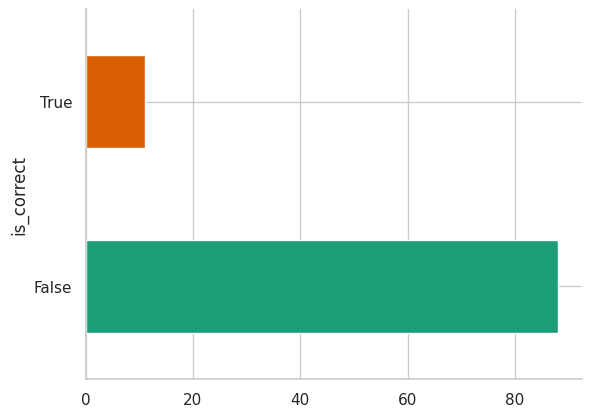

In [17]:
# seaborn bar plot of correct and incorrect answers
from matplotlib import pyplot as plt
import seaborn as sns
additions_df_enforced.groupby('is_correct').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

What is the accuracy (percentage) ? => slightly improved

In [18]:
# accuracy percentage
print(f"Average accuracy : {additions_df_enforced.is_correct.mean()*100:.02f}%")

Average accuracy : 11.11%


/tmp/ipykernel_43/926448399.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


Text(0.5, 0, 'Sum')

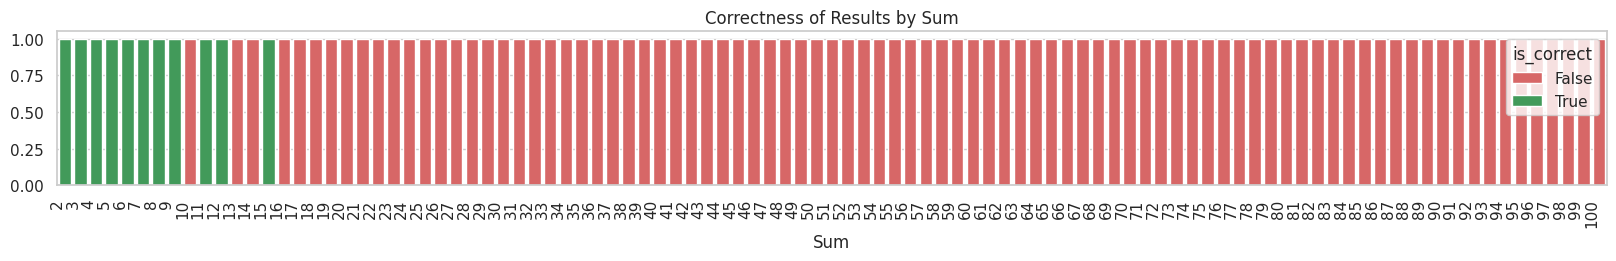

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Order the results
results = additions_df_enforced['result'].astype(int).unique()
results.sort()

# set the high and width
plt.figure(figsize=(20, 2))

# Create the barplot
g = sns.barplot(x="result", y=[1]*len(additions_df_enforced), data=additions_df_enforced, order=results, hue="is_correct", palette=["#EA5455", "#34A853"])

# pivot label
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")

# Add title and labels
plt.title("Correctness of Results by Sum")
plt.xlabel("Sum")


/tmp/ipykernel_43/1530401180.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


Text(0.5, 0, 'Sum')

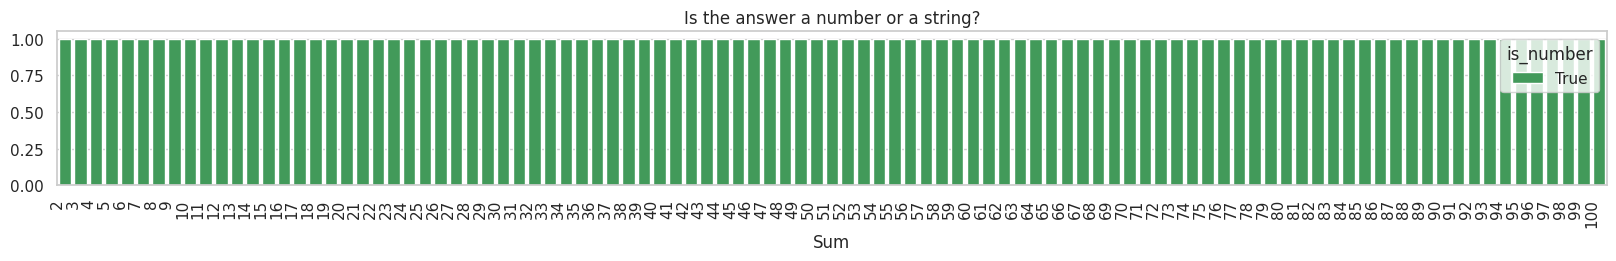

In [20]:
# Apply the function to create a new column
additions_df_enforced['is_number'] = additions_df_enforced['inferred_answer'].apply(check_type)


# Order the results
results = additions_df_enforced['result'].astype(int).unique()
results.sort()

# set the high and width
plt.figure(figsize=(20, 2))

# Create the barplot
g = sns.barplot(x="result", y=[1]*len(additions_df_enforced), data=additions_df_enforced, order=results, hue="is_number", palette={False:"#EA5455", True:"#34A853"})

# pivot label
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")

# Add title and labels
plt.title("Is the answer a number or a string?")
plt.xlabel("Sum")

## MMLU style multi choice dataset  

We will create 4 choices for each sum result.  
To prevent confusion with the expected number result, we will ask the LLM to predict a letter.  

About the 4 choices:  
- we will pick 4 random values between 2 and 100  
- we will replace one of these values with the correct answer  
- we will replace another one of these values with an answer that is 1 above or below the correct answer

### update the dataset to add choices

In [21]:
# get random value between 2 and 100
import random
random_values = [random.randint(2, 100) for _ in range(4)]
random_values

[19, 18, 36, 11]

In [22]:
answer = 42

def add_answer_to_choices(choices, answer):
  # if answer is present in the random values, collect its index
  if answer in choices:
    answer_position = choices.index(answer)
  # else: create a random index between 0 and 3 and insert the answer
  else:
    answer_position = random.randint(0, 3)
    choices[answer_position] = answer
  return choices, answer_position

choices, answer_position = add_answer_to_choices(random_values, answer)
choices, answer_position

([42, 18, 36, 11], 0)

In [23]:
# we take the answer and randomly add or substract one
fake_answer = answer + random.choice([-1, 1])

def add_fake_answer_to_choices(choices, fake_answer, answer_position):
  # if fake answer is present in the choices, do nothing
  # else
  if fake_answer not in choices:
    # get random index that doesn't contain answer_position
    fake_answer_position = random.choice([i for i in range(4) if i != answer_position])
    choices[fake_answer_position] = fake_answer
  return choices

choices = add_fake_answer_to_choices(choices, fake_answer, answer_position)
choices

[42, 18, 36, 41]

In [24]:
def create_mmlu_style_dataset(row):
  random_values = [random.randint(2, 100) for _ in range(4)]

  answer = int(row['result'])
  choices, answer_position = add_answer_to_choices(random_values, answer)

  fake_answer = answer + random.choice([-1, 1])
  choices = add_fake_answer_to_choices(choices, fake_answer, answer_position)

  row['choices'] = choices
  row['answer_position'] = answer_position

  return row

additions_df_mmlu = additions_df.apply(lambda row: create_mmlu_style_dataset(row), axis=1)
additions_df_mmlu.head()

,sum,result,inferred_answer,is_correct,is_number,choices,answer_position
1,1+1,2,2,True,True,"[83, 3, 2, 47]",2
2,1+1+1,3,3,True,True,"[4, 99, 3, 15]",2
3,1+1+1+1,4,4,True,True,"[28, 3, 9, 4]",3
4,1+1+1+1+1,5,5,True,True,"[5, 60, 4, 61]",0
5,1+1+1+1+1+1,6,6,True,True,"[16, 5, 6, 18]",2


### add expected answer letter `answer_letter`  

The `answer_letter` feature contains the letter that corresponds to the answer.  

Eg.  

What is the result of 1+1 ?  

A. 55  
B. 19  
C. 2  
D. 3  

Correct answer is C, so `answer_letter = C`

In [25]:
# convert 0-3 int to A-D letter
def get_letter(index):
  return chr(ord('A') + index)

In [26]:
additions_df_mmlu['answer_letter'] = additions_df_mmlu.apply(lambda row: get_letter(row['answer_position']), axis=1)
additions_df_mmlu.head()

,sum,result,inferred_answer,is_correct,is_number,choices,answer_position,answer_letter
1,1+1,2,2,True,True,"[83, 3, 2, 47]",2,C
2,1+1+1,3,3,True,True,"[4, 99, 3, 15]",2,C
3,1+1+1+1,4,4,True,True,"[28, 3, 9, 4]",3,D
4,1+1+1+1+1,5,5,True,True,"[5, 60, 4, 61]",0,A
5,1+1+1+1+1+1,6,6,True,True,"[16, 5, 6, 18]",2,C


## Use output enforcer to choose MMLU answer  

#### format choices in MMLU style

In [27]:
# format choices to have a list of A to D answers
def format_choice(choices):

  letters = ["A", "B", "C", "D"]

  lines = []
  for letter, choice in zip(letters, choices):
    lines.append(f"  {letter}. {choice}  ")

  return "\n".join(lines) + '\n'

example_choices = [55, 19, 2, 3]
print(format_choice(example_choices))

  A. 55  
  B. 19  
  C. 2  
  D. 3  



#### update prompt to MMLU style

In [28]:
# after getting devastating results, we add one shot example to the prompt
mmlu_style_prompt = """
Answer the following multiple choice question.
The last line of your response should be of the following format: 'The answer is : $LETTER' (without quotes) where LETTER is one of A B C D.
Think step by step before answering.

Question: What is the sum of : 2+2
Choices:
A. 55
B. 19
C. 4
D. 3

The answer is : C

Question: What is the sum of : 3+3
Choices:
A. 6
B. 19
C. 4
D. 3

The answer is : A

Question: What is the sum of : 4+4
Choices:
A. 55
B. 8
C. 4
D. 3

The answer is : B

Question: What is the sum of : 5+5
Choices:
A. 55
B. 19
C. 4
D. 10

The answer is : D

Question: What is the sum of : {}
Choices:
{}

The answer is : {}"""

In [29]:
example_question = '1+1'

print(mmlu_style_prompt.format(
          example_question, # question
          format_choice(example_choices), # choices
          "", # output - leave this blank for generation!
      ))


Answer the following multiple choice question.
The last line of your response should be of the following format: 'The answer is : $LETTER' (without quotes) where LETTER is one of A B C D.
Think step by step before answering.

Question: What is the sum of : 2+2
Choices:
A. 55
B. 19
C. 4
D. 3

The answer is : C

Question: What is the sum of : 3+3
Choices:
A. 6
B. 19
C. 4
D. 3

The answer is : A

Question: What is the sum of : 4+4
Choices:
A. 55
B. 8
C. 4
D. 3

The answer is : B

Question: What is the sum of : 5+5
Choices:
A. 55
B. 19
C. 4
D. 10

The answer is : D

Question: What is the sum of : 1+1
Choices:
  A. 55  
  B. 19  
  C. 2  
  D. 3  


The answer is : 


#### update inference function  

Finally, update the regex and declare new inference function with the previous changes


In [30]:
tokenizer_data = build_token_enforcer_tokenizer_data(tokenizer)

# regex for a single letter between A and D
required_regex = r"[ABCD]"
parser = RegexParser(required_regex)

In [31]:
def get_enforced_answer_to_question_mmlu_style(question, choices):

  prompt = mmlu_style_prompt.format(
          question, # question
          format_choice(choices), # choices
          "", # output - leave this blank for generation!
      )

  inputs = tokenizer([prompt], return_tensors = "pt").to("cuda")

  # outputs = model.generate(**inputs, max_new_tokens = 2, use_cache = True)
  outputs = generate_enforced(model, tokenizer_data, parser, **inputs)
  return (tokenizer.batch_decode(outputs, skip_special_tokens=True)[0][len(prompt)-1:].strip())

get_enforced_answer_to_question_mmlu_style(example_question, example_choices)

'C'

### Apply MMLU style inference function to complete dataset

In [32]:
additions_df_mmlu['inferred_letter_answer'] = additions_df_mmlu.progress_apply(lambda row: get_enforced_answer_to_question_mmlu_style(row['sum'], row['choices']), axis=1)
additions_df_mmlu.head()

  0%|          | 0/99 [00:00<?, ?it/s]

,sum,result,inferred_answer,is_correct,is_number,choices,answer_position,answer_letter,inferred_letter_answer
1,1+1,2,2,True,True,"[83, 3, 2, 47]",2,C,B
2,1+1+1,3,3,True,True,"[4, 99, 3, 15]",2,C,A
3,1+1+1+1,4,4,True,True,"[28, 3, 9, 4]",3,D,A
4,1+1+1+1+1,5,5,True,True,"[5, 60, 4, 61]",0,A,A
5,1+1+1+1+1+1,6,6,True,True,"[16, 5, 6, 18]",2,C,A


In [33]:
additions_df_mmlu['is_correct_letter'] = additions_df_mmlu['answer_letter'] == additions_df_mmlu['inferred_letter_answer']

In [34]:
# get mean is_correct_letter accuracy
print(f"Average accuracy : {additions_df_mmlu.is_correct_letter.mean()*100:.02f}%")

Average accuracy : 28.28%


/tmp/ipykernel_43/1521889404.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


Text(0.5, 0, 'Sum')

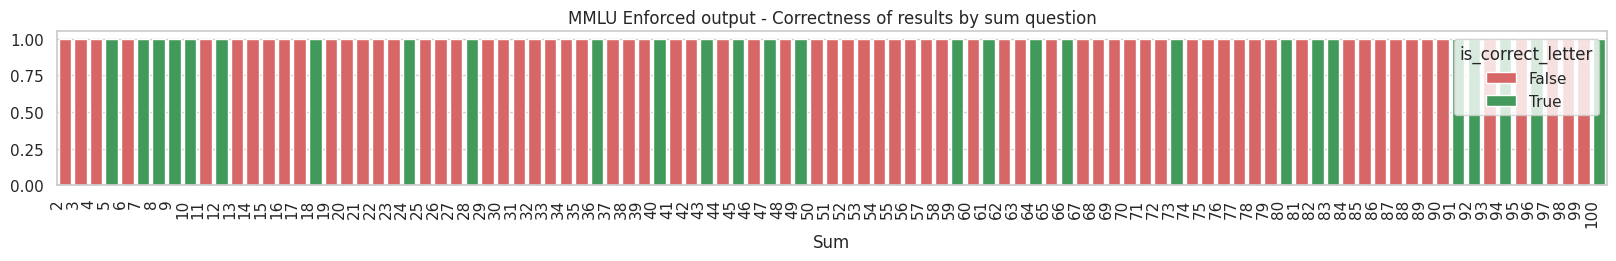

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Order the results
results = additions_df_mmlu['result'].astype(int).unique()
results.sort()

# set the high and width
plt.figure(figsize=(20, 2))

# Create the barplot
g = sns.barplot(x="result", y=[1]*len(additions_df_mmlu), data=additions_df_mmlu, order=results, hue="is_correct_letter", palette=["#EA5455", "#34A853"])

# pivot label
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")

# Add title and labels
plt.title("MMLU Enforced output - Correctness of results by sum question")
plt.xlabel("Sum")


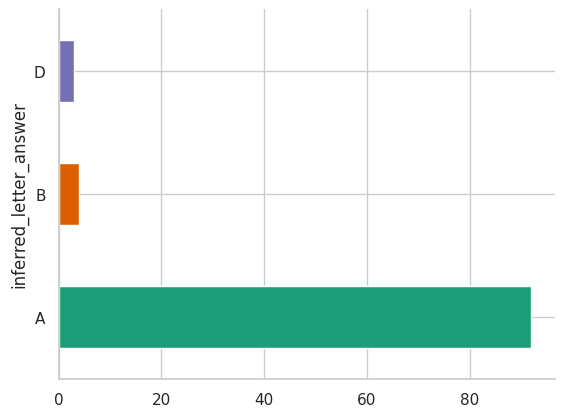

In [36]:
# @title inferred_letter_answer

from matplotlib import pyplot as plt
import seaborn as sns
additions_df_mmlu.groupby('inferred_letter_answer').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Measure token probas at the last layer  

We use the standard method to evaluate MMLU instead of the output enforcer (with regex).  

We want to see if results change when bypassing the decision tree.  

In [37]:
additions_df_mmlu.head()

,sum,result,inferred_answer,is_correct,is_number,choices,answer_position,answer_letter,inferred_letter_answer,is_correct_letter
1,1+1,2,2,True,True,"[83, 3, 2, 47]",2,C,B,False
2,1+1+1,3,3,True,True,"[4, 99, 3, 15]",2,C,A,False
3,1+1+1+1,4,4,True,True,"[28, 3, 9, 4]",3,D,A,False
4,1+1+1+1+1,5,5,True,True,"[5, 60, 4, 61]",0,A,A,True
5,1+1+1+1+1+1,6,6,True,True,"[16, 5, 6, 18]",2,C,A,False


#### new inference function to measure probas for ABCD tokens  

We retrieve a batch inference function for MMLU from a previous notebook:
https://colab.research.google.com/drive/1NBG5HPiEz2E0HJhSVVlxbDhhc40quXN4#scrollTo=UIst6bZ2CFlQ  

And adapt it to our current feature names and current prompt.  

In [38]:
# V0 : use tokens " A" etc... for answer matching
# use model forward for inference and logits retrieval (one pass)
def get_number_result_from_question_batch_mode_v0(rows):

    prompts = []
    for question, choices in zip(rows['sum'], rows['choices']):
        prompt = mmlu_style_prompt.format(
            question, # question
            format_choice(choices), # choices
            "", # output - leave this blank for generation!
        )
        prompts.append(prompt)

    answer_tokens = tokenizer.encode(" A B C D", add_special_tokens=False, return_tensors="pt")
    inputs = tokenizer(prompts, return_tensors="pt", padding=True).to("cuda")

    logits_list = []
    with torch.no_grad():
        logits = model.forward(inputs.input_ids, attention_mask=inputs.attention_mask).logits
        torch.cuda.empty_cache()
        for i in range(len(prompts)):
            logits_ans = logits[i, -1, answer_tokens].cpu()
            logits_list.append(logits_ans)

    rows['inferred_letter_answer'] = []
    for logits_ans in logits_list:
        prob_ans = torch.softmax(logits_ans, dim=-1)
        inferred_answer = prob_ans.argmax(dim=-1)[0]
        rows['inferred_letter_answer'].append(inferred_answer.item())

    return rows

# V1 : use tokens "A" etc... for answer matching
# use model forward for inference and logits retrieval (one pass)
def get_number_result_from_question_batch_mode_v1(rows):

    prompts = []
    for question, choices in zip(rows['sum'], rows['choices']):
        prompt = mmlu_style_prompt.format(
            question, # question
            format_choice(choices), # choices
            "", # output - leave this blank for generation!
        )
        prompts.append(prompt)

    answer_tokens = torch.tensor([
      tokenizer.encode("A", add_special_tokens=False)[0],
      tokenizer.encode("B", add_special_tokens=False)[0],
      tokenizer.encode("C", add_special_tokens=False)[0],
      tokenizer.encode("D", add_special_tokens=False)[0]
    ])
    inputs = tokenizer(prompts, return_tensors="pt", padding=True).to("cuda")

    logits_list = []
    with torch.no_grad():
        logits = model.forward(inputs.input_ids, attention_mask=inputs.attention_mask).logits
        torch.cuda.empty_cache()
        for i in range(len(prompts)):
            logits_ans = logits[i, -1, answer_tokens].cpu()
            logits_list.append(logits_ans)

    rows['inferred_letter_answer'] = []
    for logits_ans in logits_list:
        prob_ans = torch.softmax(logits_ans, dim=-1)
        inferred_answer = prob_ans.argmax(dim=-1)
        rows['inferred_letter_answer'].append(inferred_answer.item())

    return rows

# V2 : use tokens "A" etc... for answer matching
# use model generate for inference and model(**inputs) for logits retrieval (two pass)
def get_number_result_from_question_batch_mode_v2(rows):

  prompts = []
  for question, choices in zip(rows['sum'], rows['choices']):
      prompt = mmlu_style_prompt.format(
          question, # question
          format_choice(choices), # choices
          "", # output - leave this blank for generation!
      )
      prompts.append(prompt)
      # print(prompt)

  answer_tokens = torch.tensor([
  tokenizer.encode("A", add_special_tokens=False)[0],
  tokenizer.encode("B", add_special_tokens=False)[0],
  tokenizer.encode("C", add_special_tokens=False)[0],
  tokenizer.encode("D", add_special_tokens=False)[0]
  ])

  inputs = tokenizer(prompts, return_tensors="pt", padding=True).to("cuda")

  logits_list = []
  with torch.no_grad():
      response = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=1,
        return_dict_in_generate=True,
        output_logits=True
      )

      logits = model(input_ids=response.sequences).logits
      torch.cuda.empty_cache()
      for i in range(len(prompts)):
          logits_ans = logits[i, -1, answer_tokens].cpu()
          logits_list.append(logits_ans)

  rows['inferred_letter_answer'] = []
  for logits_ans in logits_list:
      prob_ans = torch.softmax(logits_ans, dim=-1)
      inferred_answer = prob_ans.argmax(dim=-1)
      rows['inferred_letter_answer'].append(inferred_answer.item())

  return rows

# V3 : use tokens " A" etc... for answer matching
# use model generate for inference and model(**inputs) for logits retrieval (two pass)
def get_number_result_from_question_batch_mode_v3(rows):

  prompts = []
  for question, choices in zip(rows['sum'], rows['choices']):
      prompt = mmlu_style_prompt.format(
          question, # question
          format_choice(choices), # choices
          "", # output - leave this blank for generation!
      )
      prompts.append(prompt)
      # print(prompt)

  answer_tokens = torch.tensor([
  tokenizer.encode(" A", add_special_tokens=False)[0],
  tokenizer.encode(" B", add_special_tokens=False)[0],
  tokenizer.encode(" C", add_special_tokens=False)[0],
  tokenizer.encode(" D", add_special_tokens=False)[0]
  ])

  inputs = tokenizer(prompts, return_tensors="pt", padding=True).to("cuda")

  logits_list = []
  with torch.no_grad():
      response = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=1,
        return_dict_in_generate=True,
        output_logits=True
      )

      logits = model(input_ids=response.sequences).logits
      torch.cuda.empty_cache()
      for i in range(len(prompts)):
          logits_ans = logits[i, -1, answer_tokens].cpu()
          logits_list.append(logits_ans)

  rows['inferred_letter_answer'] = []
  for logits_ans in logits_list:
      prob_ans = torch.softmax(logits_ans, dim=-1)
      inferred_answer = prob_ans.argmax(dim=-1)
      rows['inferred_letter_answer'].append(inferred_answer.item())

  return rows

Below, we test the 4 versions of MMLU probas inference functions:

In [39]:
input = {
    'sum': ["1+2", "2+2"],
    'choices': [["55", "19", "4", "3"], ["4", "19", "55", "3"]]
}

In [40]:
get_number_result_from_question_batch_mode_v0(input)

{'sum': ['1+2', '2+2'],
 'choices': [['55', '19', '4', '3'], ['4', '19', '55', '3']],
 'inferred_letter_answer': [2, 0]}

In [41]:
get_number_result_from_question_batch_mode_v1(input)

{'sum': ['1+2', '2+2'],
 'choices': [['55', '19', '4', '3'], ['4', '19', '55', '3']],
 'inferred_letter_answer': [1, 0]}

In [42]:
get_number_result_from_question_batch_mode_v2(input)

{'sum': ['1+2', '2+2'],
 'choices': [['55', '19', '4', '3'], ['4', '19', '55', '3']],
 'inferred_letter_answer': [3, 1]}

In [43]:
get_number_result_from_question_batch_mode_v3(input)

{'sum': ['1+2', '2+2'],
 'choices': [['55', '19', '4', '3'], ['4', '19', '55', '3']],
 'inferred_letter_answer': [0, 1]}

Over this small sample, we find the V3 is the best performer.  
We will use this inference function for the complete dataset.  

#### perform batch inference (over dataset)  

We need to temporarily convert the dataframe to a huggingface dataset to use our batch processing inference function.  

In [44]:
# disable caching to make sure our new results are refreshed
import datasets
datasets.disable_caching()

In [45]:
from datasets import Dataset

batch_dataset = Dataset.from_pandas(additions_df_mmlu)

In [46]:
batch_dataset = batch_dataset.map(get_number_result_from_question_batch_mode_v2, batched=True, batch_size=10, num_proc=1)

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Switch back to pandas DF and clean up old features

In [47]:
additions_df_mmlu_alt = batch_dataset.to_pandas()
del additions_df_mmlu_alt['__index_level_0__']
del additions_df_mmlu_alt['is_correct_letter']

In [48]:
additions_df_mmlu_alt.head()

,sum,result,inferred_answer,is_correct,is_number,choices,answer_position,answer_letter,inferred_letter_answer
0,1+1,2,2,True,True,"[83, 3, 2, 47]",2,C,0
1,1+1+1,3,3,True,True,"[4, 99, 3, 15]",2,C,1
2,1+1+1+1,4,4,True,True,"[28, 3, 9, 4]",3,D,3
3,1+1+1+1+1,5,5,True,True,"[5, 60, 4, 61]",0,A,1
4,1+1+1+1+1+1,6,6,True,True,"[16, 5, 6, 18]",2,C,0


Convert our index answer to a letter

In [49]:
additions_df_mmlu_alt['inferred_letter_answer'] = additions_df_mmlu_alt.apply(lambda row: get_letter(row['inferred_letter_answer']), axis=1)
additions_df_mmlu_alt.head()

,sum,result,inferred_answer,is_correct,is_number,choices,answer_position,answer_letter,inferred_letter_answer
0,1+1,2,2,True,True,"[83, 3, 2, 47]",2,C,A
1,1+1+1,3,3,True,True,"[4, 99, 3, 15]",2,C,B
2,1+1+1+1,4,4,True,True,"[28, 3, 9, 4]",3,D,D
3,1+1+1+1+1,5,5,True,True,"[5, 60, 4, 61]",0,A,B
4,1+1+1+1+1+1,6,6,True,True,"[16, 5, 6, 18]",2,C,A


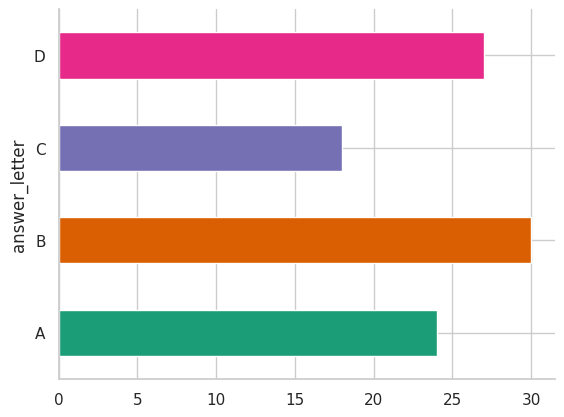

In [50]:
# @title answer_letter

from matplotlib import pyplot as plt
import seaborn as sns
additions_df_mmlu_alt.groupby('answer_letter').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

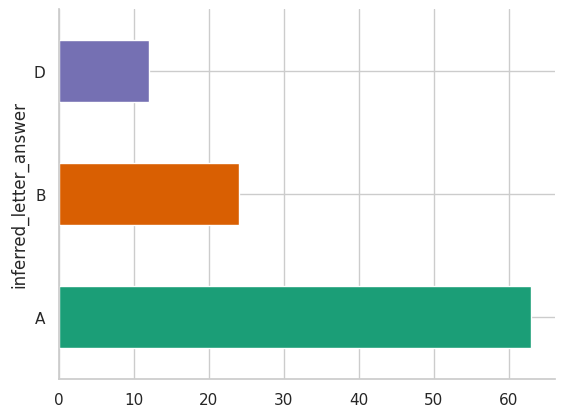

In [51]:
# @title inferred_letter_answer

from matplotlib import pyplot as plt
import seaborn as sns
additions_df_mmlu_alt.groupby('inferred_letter_answer').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [52]:
additions_df_mmlu_alt['is_correct_letter'] = additions_df_mmlu_alt['answer_letter'] == additions_df_mmlu_alt['inferred_letter_answer']

In [53]:
additions_df_mmlu_alt.head()

,sum,result,inferred_answer,is_correct,is_number,choices,answer_position,answer_letter,inferred_letter_answer,is_correct_letter
0,1+1,2,2,True,True,"[83, 3, 2, 47]",2,C,A,False
1,1+1+1,3,3,True,True,"[4, 99, 3, 15]",2,C,B,False
2,1+1+1+1,4,4,True,True,"[28, 3, 9, 4]",3,D,D,True
3,1+1+1+1+1,5,5,True,True,"[5, 60, 4, 61]",0,A,B,False
4,1+1+1+1+1+1,6,6,True,True,"[16, 5, 6, 18]",2,C,A,False


#### Measure accuracy

 old : 27.27%

In [54]:
# accuracy
print(f"Average accuracy : {additions_df_mmlu_alt.is_correct_letter.mean()*100:.02f}%")

Average accuracy : 21.21%


We find that the current accuracy is equal to random baseline: we have achieved the same result as a 4-side coin flip...

/tmp/ipykernel_43/1894718588.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


Text(0.5, 0, 'Sum')

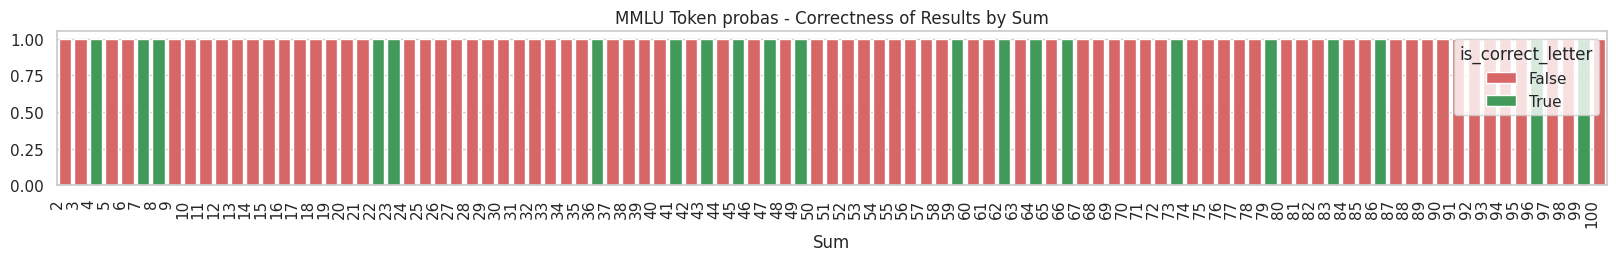

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Order the results
results = additions_df_mmlu_alt['result'].astype(int).unique()
results.sort()

# set the high and width
plt.figure(figsize=(20, 2))

# Create the barplot
g = sns.barplot(x="result", y=[1]*len(additions_df_mmlu_alt), data=additions_df_mmlu_alt, order=results, hue="is_correct_letter", palette=["#EA5455", "#34A853"])

# pivot label
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")

# Add title and labels
plt.title("MMLU Token probas - Correctness of Results by Sum")
plt.xlabel("Sum")


## Test the RAG hypothesis  

What is we let the model answer with max 10 new tokens per sum, and then perform RAG on the MMLU choices?  

This method could prove successful as the open ended method has the best results, and seems to be constrained by the output enforcer.  
By removing this constraint, we could achieve higher results.  

### compute embeddings for all answers from 2 to 99  

In [56]:
import faiss

In [57]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = embedding_model.encode(sentences)
print(embeddings.shape)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(2, 384)


In [58]:
del additions_df['is_correct']
del additions_df['is_number']
del additions_df['inferred_answer']

In [59]:
additions_df.head()

,sum,result
1,1+1,2
2,1+1+1,3
3,1+1+1+1,4
4,1+1+1+1+1,5
5,1+1+1+1+1+1,6


In [60]:
additions_df['result_embedding'] = list(embedding_model.encode(additions_df.result.to_list()))
additions_df.head()

,sum,result,result_embedding
1,1+1,2,"[-0.028164797, -0.024786523, -0.09065126, 0.04..."
2,1+1+1,3,"[-0.02898982, -0.031059038, -0.094503745, 0.02..."
3,1+1+1+1,4,"[0.046898987, 0.00025665484, -0.08567224, 0.00..."
4,1+1+1+1+1,5,"[-0.04131201, -0.006703235, -0.031351097, 0.03..."
5,1+1+1+1+1+1,6,"[-0.0033216532, 0.004443928, -0.08935938, 0.04..."


### Create a FAISS index dataset to search for matches

In [61]:
from datasets import Dataset

additions_ds = Dataset.from_pandas(additions_df, preserve_index=False)
additions_ds

Dataset({
    features: ['sum', 'result', 'result_embedding'],
    num_rows: 99
})

In [62]:
additions_ds.add_faiss_index(column='result_embedding')

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['sum', 'result', 'result_embedding'],
    num_rows: 99
})

In [63]:
def get_nearest_number_for_answer(long_form_answer):
  response_embedding = embedding_model.encode(long_form_answer)

  retrieved_examples = additions_ds.get_nearest_examples('result_embedding', response_embedding, k=1)
  return int(retrieved_examples.examples['result'][0])

long_form_answer = 'The answer is : 19'
get_nearest_number_for_answer(long_form_answer)

19

### generate open ended answers for all questions (64 tokens)  

We allow the LLM to generate up to 64 new tokens to answer each question.  
This will be long in some instances, but needed to get a truthfull answer.  

In [64]:
def get_open_ended_answer_to_question(question):

  prompt = alpaca_prompt.format(
          "Compute the result of this sum.", # instruction
          question, # input
          "", # output - leave this blank for generation!
      )

  inputs = tokenizer([prompt], return_tensors = "pt").to("cuda")

  outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
  return (tokenizer.batch_decode(outputs, skip_special_tokens=True)[0][len(prompt):].strip())

response = get_open_ended_answer_to_question('1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1')
print(response)

The result of this sum is 32.


In [65]:
from tqdm.auto import tqdm

tqdm.pandas()

additions_df_long_form = additions_df.copy(deep=True)
del additions_df_long_form['result_embedding']

additions_df_long_form['inferred_answer'] = additions_df_long_form.progress_apply(lambda row: get_open_ended_answer_to_question(row['sum']), axis=1)
additions_df_long_form.head()

  0%|          | 0/99 [00:00<?, ?it/s]

,sum,result,inferred_answer
1,1+1,2,2
2,1+1+1,3,3
3,1+1+1+1,4,4
4,1+1+1+1+1,5,5
5,1+1+1+1+1+1,6,6


In [66]:
additions_df_long_form['rag_answer'] = additions_df_long_form.progress_apply(lambda row: get_nearest_number_for_answer(row['inferred_answer']), axis=1)
additions_df_long_form.head()

  0%|          | 0/99 [00:00<?, ?it/s]

,sum,result,inferred_answer,rag_answer
1,1+1,2,2,2
2,1+1+1,3,3,3
3,1+1+1+1,4,4,4
4,1+1+1+1+1,5,5,5
5,1+1+1+1+1+1,6,6,6


### Measure accuracy

In [67]:
additions_df_long_form['is_correct'] = additions_df_long_form['result'].astype(int) == additions_df_long_form['rag_answer']

In [68]:
additions_df_long_form.head()

,sum,result,inferred_answer,rag_answer,is_correct
1,1+1,2,2,2,True
2,1+1+1,3,3,3,True
3,1+1+1+1,4,4,4,True
4,1+1+1+1+1,5,5,5,True
5,1+1+1+1+1+1,6,6,6,True


In [69]:
# accuracy
print(f"Average accuracy : {additions_df_long_form.is_correct.mean()*100:.02f}%")

Average accuracy : 13.13%


/tmp/ipykernel_43/54747527.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


Text(0.5, 0, 'Sum')

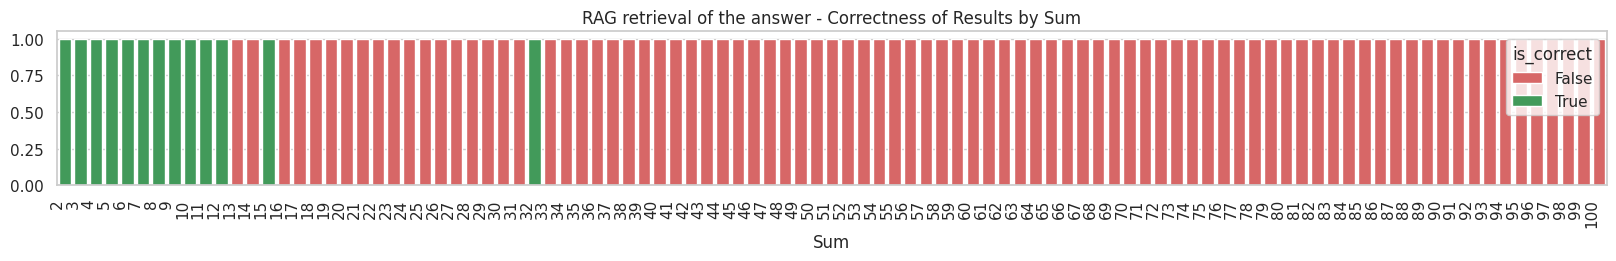

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Order the results
results = additions_df_long_form['result'].astype(int).unique()
results.sort()

# set the high and width
plt.figure(figsize=(20, 2))

# Create the barplot
g = sns.barplot(x="result", y=[1]*len(additions_df_long_form), data=additions_df_long_form, order=results, hue="is_correct", palette=["#EA5455", "#34A853"])

# pivot label
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")

# Add title and labels
plt.title("RAG retrieval of the answer - Correctness of Results by Sum")
plt.xlabel("Sum")


Contrary to our initial hypothesis: when the model answers using a sentence, it is always wrong! (well, 99.9% of the time, because it got lucky once).

However, our RAG system seems to be working great! We are able to retrieve the correct number from the LLM output 100% of the time.  

In [71]:
additions_df_long_form[additions_df_long_form.inferred_answer.str.contains('The result of this sum')]

,sum,result,inferred_answer,rag_answer,is_correct
25,1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+...,26,The result of this sum is 32.,32,False
26,1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+...,27,The result of this sum is 32.\n\n### Explanati...,32,False
27,1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+...,28,The result of this sum is 32.,32,False
28,1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+...,29,The result of this sum is 32.,32,False
29,1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+...,30,The result of this sum is 32.,32,False
...,...,...,...,...,...
95,1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+...,96,The result of this sum is 31.,31,False
96,1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+...,97,The result of this sum is 31.,31,False
97,1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+...,98,The result of this sum is 31.,31,False
98,1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+...,99,The result of this sum is 31.,31,False


## Conclusion  

Depending on the method used, the benchmarks has wildly different results.  

MMLU method yields poorer results, with a 25% random baseline that gives the impression that the model can perform on a greater range than it actually can.  

The open ended version is the best, with the output enforcer to control the results (force the use of digits to express the anwer).  
Right behind is the RAG version, which has the potential of solving more difficult MMLU questions.  

All attempts to constrain the model to answer by a letter representing the correct response have been a failure, from proba measure, to output enforcer. No prompt could satisfy both the need to get better results and more consistent results. We even managed to get a score worse than random on some runs...(under 25% correct answers).  

The current model being evaluated can only count up to 16.  

Due to the nature of the LLM being tested, an 8B Q4 variant, we have even more difficulties imparting instructions via prompts, and 5 shots might be under an unknown thereshold. Maybe MMLU evals need 70B models to work?